Plotting Best Kinetics Fits


/Users/Justin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:164: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


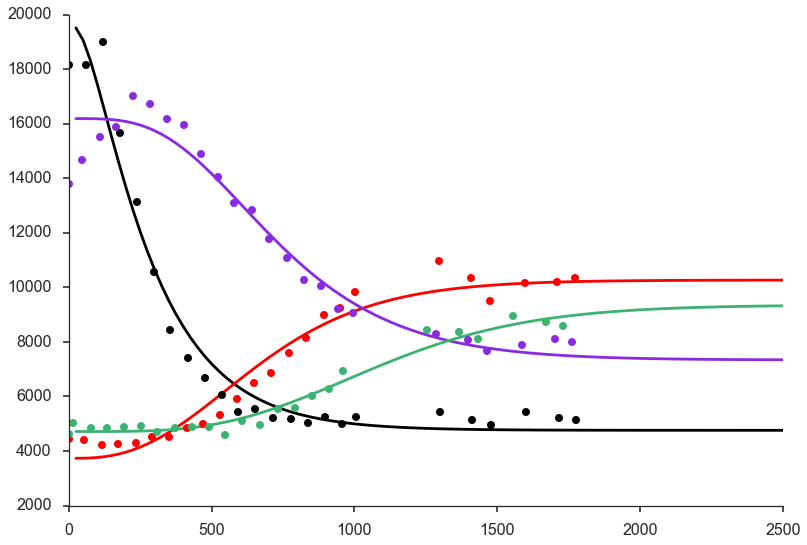

In [3]:

import os
import glob
import numpy as np
from scipy import integrate
import pylab as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
################################### Modeling Definitions ###################################

def cascade_kinetics(t, r, a, k, b, u, n):
    layer_depth = len(r) - 1
    dR = [0] * len(r)
    dR[layer_depth] = u - b * r[layer_depth]
    for l in range(layer_depth)[::-1]:
        dR[l] = a[l] / (1+k[l] * r[l+1] ** n) - b * r[l]
    return dR

def cascade_ss(layer_depth, a, k, b, u, n):
    assert len(a) == len(k)
    assert len(a) >= layer_depth
    R = [0]*(layer_depth+1)
    R[layer_depth] = u/b
    for l in range(layer_depth)[::-1]:
        R[l] = a[l] / ((1+k[l] * R[l+1] ** n)*b)
    return np.array(R)

def tfxn(inducer_at_max, inducer):
    AB = 542.8745566
    K = 0.269635359
    n = 1.238933919
    def fxn(u):
        return (AB*K*u**n)/(1+K*u**n)
    rel_induction = fxn(inducer)/fxn(inducer_at_max)
    return rel_induction

t_final = 500.
dt = 1.0


def integrateSystem(numlayers, a, k, b, u, n):
    ss = cascade_ss(numlayers, a, k, b, 0.0, n)
    r1 = integrate.ode(cascade_kinetics)
    r1.set_initial_value(ss).set_f_params(a, k, b, u, n)
    data1 = []
    while r1.successful() and r1.t < t_final:
        r1.integrate(r1.t+dt)
        data1.append( [r1.t] + [float(i) for i in list(r1.y)] )
    return data1


def ssModel(i_array, a, k, b, u, n):
    assert len(a) == len(k)
    num_layers = len(a)+1
    dose = pd.DataFrame(index = i_array, columns = list(range(1,num_layers+1)) + ['rel exp'])
    for i in i_array:
        rel_exp = tfxn(100.0, i)
        rel_u = rel_exp * u
        dose.loc[i] = [cascade_ss(l, a, k, b, rel_u, n)[0] for l in range(num_layers)] + [rel_exp]
    return dose


def kineticsModel(a, k, b, u, n):
    assert len(a) == len(k)
    num_layers = len(a)+1
    layers = {}
    time = []
    for l in range(num_layers):
        system = integrateSystem(l, a, k, b, u, n)
        unzipped = zip(*system)
        layers[l] = unzipped[1]
        time = unzipped[0]
    return pd.DataFrame(layers, index=time)


def getTimeToHalfMaximum(trajectory, init, ss, ds):
    half = ss - init
    half = half/2.0
    half = ss - half
    ttss = []
    g = np.abs(trajectory - half)
    ttss = g.apply(np.argmin)
    return ttss

def getValue(t, df):
    i = np.abs(df.index - t).argmin()
    return df.iloc[i]

def cascadesystem_steadystate_simple(numlayers, a, k, b, u, n):

    Y = []
    Y.append(u/b)
    for i in range(numlayers):
        Y.append((1.*a/(1+k*Y[i]**n))/b)
    return np.array(Y)

def dynamic_range_plot(numlayers, a, k, b, u, n):
    params = [a,k,b,u,n]
    ss = cascadesystem_steadystate_simple(numlayers, *params)
    params = [a, k, b, 0.0, n]
    ss_0 = cascadesystem_steadystate_simple(numlayers, *params)
    #plt.yscale('log')
    #plt.plot(np.log10(np.abs(ss-ss_0)))
    dr = []
    for ss_value, ss_0_value in zip(ss, ss_0):
        values = [ss_value, ss_0_value]
        dr.append(max(values)/min(values))
    #return np.abs(ss-ss_0)
    metric = 20.0*np.log10(dr)
    #metric = np.abs(ss-ss_0)
    plt.plot(metric)
    return metric

################################### Define Filenames ###################################
#user = "soslab"
user = "Justin"
root = os.path.join("/Users/", user, "Documents/Programming/CRISPRCascadeAnalysis/160104/")
datafolder = os.path.join(root, "Data")
montecarlofolder = os.path.join(datafolder, "MonteCarlo")
hyakfolder = os.path.join(datafolder, "hyakfitting_results")
kinetics_filename = os.path.join(hyakfolder, "bestfits_kinetics_indexed.csv")
finalfolder = os.path.join(root, "FinalData")

################################### Get Best Fits ###################################
scripts = os.path.join(datafolder, "HyakFittingScripts_CascadeAnalysis_20160104", "output_fittingscript_steadystate_20160104")
files = glob.glob(os.path.join(hyakfolder, 'HyakFittingScripts_CascadeAnalysis_20160104/output_fittingscript_steadystate_20160104/', "*.csv"))
best = []
df = None
for f in files:
    df = pd.read_csv(f, header=[0,1], index_col=0)
    lastrow = df.iloc[-1]
    best.append(lastrow)
best = pd.DataFrame(best)
best = best.reset_index()
u = best['u']
b = best['b']
best.drop('u', axis=1, level=0, inplace=True)
best.drop('b', axis=1, level=0, inplace=True)
best['u','0'] = u['0']
best['b','0'] = b['0']
best.to_csv(kinetics_filename)

summary = best.describe()
summary.to_csv(os.path.join(datafolder, 'kinetics_fit_summary.csv'))

################################### Import Kinetics Data ###################################
layers = []
for i in range(1,5):
    name = os.path.join(hyakfolder, "HyakFittingScripts_CascadeAnalysis_20160104", 'ExperimentalData', "KineticsLayer%d.csv" % i)
    layers.append(pd.read_csv(name, header=None))
layers1, layers2, layers3, layers4 = layers
header = ['time', 'au']
layers1.columns = header
layers2.columns = header
layers3.columns = header
layers4.columns = header
layers1['layer'] = 1
layers2['layer'] = 2
layers3['layer'] = 3
layers4['layer'] = 4
layers = pd.concat([layers1, layers2, layers3, layers4])
layers_table = pd.pivot_table(layers, values='au', columns=['layer'], index='time')
layers.sort(columns=['time', 'layer'])
layers['au'] = layers['au'] + 2000.
layers.stack()
layers
exp_kinetics = pd.pivot_table(layers, values='au', index=['layer', 'time'])
exp_kinetics
# plt.figure()
# plt.xlabel("Time (min)")
# plt.ylabel("Fluorescence (AU)")
# plt.title("Experimental Kinetics")
# exp_kinetics[1].plot()
# exp_kinetics[2].plot()
# exp_kinetics[3].plot()
# exp_kinetics[4].plot()
# plt.show()


print "Plotting Best Kinetics Fits"
################################### Plot Best ###################################
t_final = 100.
def plotBest(infile, kout = None):
    params = infile
    params = params.loc['50%']
    a = list(params['a'])
    k = list(params['k'])
    u = float(params['u'])
    b = params['b']
    n = float(params['n'])
    b1 = b2 = b
    if len(b) == 2:
        b1, b2 = b
    else:
        b1 = float(b)
        b2 = b1
    k = kineticsModel(a, k, b1, u, n) * 1600.0 + 2000.0
    k = k.set_index(k.index * 25.0)

    # Save files
    if not kout is None:
        k.to_csv(kout)
        sns.set_context('poster')
        sns.set_style('whitegrid', {'axes.linewidth': 10.0,})
        sns.set_style('ticks')
        plt.plot(k.index, k[1], marker=None, c='black')
        plt.plot(k.index, k[2], marker=None, c='r')
        plt.plot(k.index, k[3], marker=None, c='blueviolet')
        plt.plot(k.index, k[4], marker=None, c='mediumseagreen')
        e1 = pd.DataFrame(exp_kinetics[1])
        e2 = pd.DataFrame(exp_kinetics[2])
        e3 = pd.DataFrame(exp_kinetics[3])
        e4 = pd.DataFrame(exp_kinetics[4])
        plt.plot(e1.index, e1['au'], marker='o', c='black', linestyle='None', ms=8)
        plt.plot(e2.index, e2['au'], marker='o', c='r', linestyle='None', ms=8)
        plt.plot(e3.index, e3['au'], marker='o', c='blueviolet', linestyle='None', ms=8)
        plt.plot(e4.index, e4['au'], marker='o', c='mediumseagreen', linestyle='None', ms=8)
        sns.despine()
#         exp_kinetics[1].plot()
#         exp_kinetics[2].plot()
#         exp_kinetics[3].plot()
#         exp_kinetics[4].plot()
        plotfigpath = os.path.join(os.path.dirname(kout), os.path.basename(kout).split(".")[0])
        plt.savefig(plotfigpath + ".png", format="png")
        plt.savefig(plotfigpath + ".pdf", format="pdf")

k_in = summary
k_out = os.path.join(finalfolder, 'kinetics_fit_formatted.csv')

plotBest(k_in, kout=k_out)
